In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time_ns
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score
from torchsummary import summary


/home/amer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
# shamelessly stolen from https://blog.csdn.net/weixin_42878111/article/details/134753295    i ❤️‍🔥️ csdn 

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class SelfAttention(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_channels, out_channels, 1)
        self.key = nn.Conv2d(in_channels, out_channels, 1)
        self.value = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        q = q.view(q.size(0), q.size(1), -1)
        k = k.view(k.size(0), k.size(1), -1)
        v = v.view(v.size(0), v.size(1), -1)

        attention = F.softmax(torch.bmm(q.transpose(1, 2), k), dim=-1)
        y = torch.bmm(v, attention)
        y = y.view(x.size(0), x.size(1), x.size(2), x.size(3))

        return y

class CollaborativeAttentionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CollaborativeAttentionModule, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels, 3, 1, 1)
        self.self_attention = SelfAttention(out_channels, out_channels)

    def forward(self, x):
        x = self.conv_block(x)
        x = x + self.self_attention(x)
        return x

class CoAtNet(nn.Module):
    def __init__(self, num_classes):
        super(CoAtNet, self).__init__()
        self.stem = ConvBlock(3, 8, 7, 2, 3)
        self.pool = nn.MaxPool2d(3, 2, 1)
        self.cam1 = CollaborativeAttentionModule(8, 16)
        self.cam2 = CollaborativeAttentionModule(16, 32)
        self.cam3 = CollaborativeAttentionModule(32, 64)
        self.cam4 = CollaborativeAttentionModule(64, 128)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.pool(x)
        x = self.cam1(x)
        x = self.cam2(x)
        x = self.cam3(x)
        x = self.cam4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classes = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
num_classes = len(classes)

model = CoAtNet(num_classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
print(summary(model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]           1,184
       BatchNorm2d-2          [-1, 8, 112, 112]              16
              ReLU-3          [-1, 8, 112, 112]               0
         ConvBlock-4          [-1, 8, 112, 112]               0
         MaxPool2d-5            [-1, 8, 56, 56]               0
            Conv2d-6           [-1, 16, 56, 56]           1,168
       BatchNorm2d-7           [-1, 16, 56, 56]              32
              ReLU-8           [-1, 16, 56, 56]               0
         ConvBlock-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 16, 56, 56]             272
           Conv2d-11           [-1, 16, 56, 56]             272
           Conv2d-12           [-1, 16, 56, 56]             272
    SelfAttention-13           [-1, 16, 56, 56]               0
CollaborativeAttentionModule-14        

In [26]:
for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

In [ ]:
# preprossing
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# load data
data_path = '/home/amer/midsem_ai_course/lung_cancer'

full_dataset = torchvision.datasets.ImageFolder(data_path, transform=transform)

train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
images, labels = train_dataset[0]


plt.imshow(images.permute(1, 2, 0).numpy())
# print(images[0])
print(labels)


In [97]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [30]:
# evualation function
def evaluate(model, test_loader, device, print_matrices=False):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted_output = model(images).to(device)
            _, predicted = torch.max(predicted_output.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        recall = recall_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        if print_matrices:
            print(confusion_matrix(y_true, y_pred))
            print(classification_report(y_true, y_pred))

        return recall, precision, f1

In [ ]:
recall = f1 = precision = epoch_loss = 0.0
loss_list = []
training_loss = []
num_epoch = 10
for epoch in range(num_epoch):
    model.train()
    start = time_ns()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = torch.eye(3)[labels].to(device)

        # forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate loss
        epoch_loss += loss.item()
        loss_list.append(epoch_loss)
        
    avg_loss = epoch_loss / (i+1)
    training_loss.append(avg_loss)
    epoch_loss = 0.0

    # recall, precision, f1 = evaluate(model, test_loader, device)

    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {avg_loss:.4f}, recall: {recall:0.4f}, precision: {precision:0.4f}, f1: {f1:0.4f}, Epoch Time: {(time_ns()-start)/1e9 : 0.3f} s')

Epoch [1/10], Loss: 0.2608, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  135.470 s
Epoch [2/10], Loss: 0.2610, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  138.664 s
Epoch [3/10], Loss: 0.2728, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  136.215 s
Epoch [4/10], Loss: 0.2526, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  131.522 s
Epoch [5/10], Loss: 0.2384, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  131.795 s
Epoch [6/10], Loss: 0.2473, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  130.722 s
Epoch [7/10], Loss: 0.2377, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  131.036 s
Epoch [8/10], Loss: 0.2497, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  134.796 s
Epoch [9/10], Loss: 0.2492, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  133.829 s
Epoch [10/10], Loss: 0.2530, recall: 0.0000, precision: 0.0000, f1: 0.0000, Epoch Time:  135.581 s


[0.3035203358186777, 0.2869129271039847, 0.2965641613698658, 0.3050301553494662, 0.27678161559450953, 0.26264182661623214, 0.27138974988623593, 0.2616860155231322, 0.26805854852574573, 0.269659255424622]


Text(0.5, 1.0, 'Training Loss')

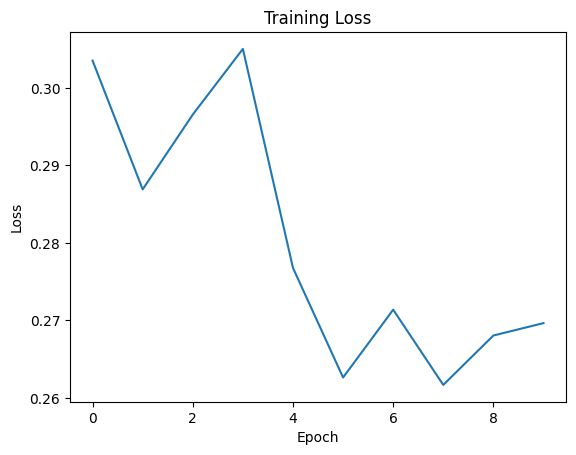

In [101]:
print(training_loss)
plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


In [102]:
evaluate(model, test_loader, device, print_matrices=True)

[[1270   17  225]
 [  20 1456    0]
 [ 105    1 1406]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1512
           1       0.99      0.99      0.99      1476
           2       0.86      0.93      0.89      1512

    accuracy                           0.92      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.92      0.92      0.92      4500



(np.float64(0.9187637114466383),
 np.float64(0.9200768065753673),
 np.float64(0.918519419732676))

In [ ]:
torch.save(model.state_dict(), 'modelv3.pth')